In [1]:
import pints
import pints.toy as toy
import matplotlib.pyplot as plt
import numpy as np



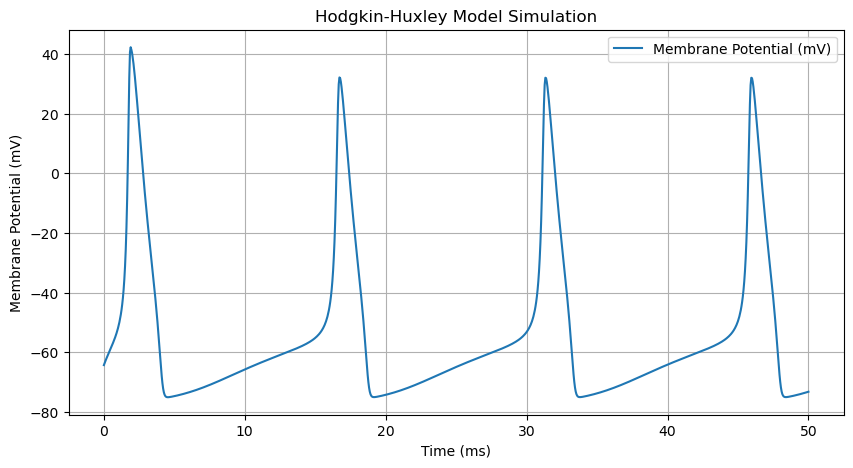

In [4]:
class HodgkinHuxley(pints.ForwardModel):
    """
    Hodgkin-Huxley neuron model as a PINTS forward model.
    """
    def __init__(self):
        super(HodgkinHuxley, self).__init__()

        # Constants
        self.C_m = 1.0    # Membrane capacitance, in uF/cm^2
        self.g_Na = 120.0  # Maximum conductances, in mS/cm^2
        self.g_K = 36.0
        self.g_L = 0.3
        self.E_Na = 50.0   # Reversal potentials, in mV
        self.E_K = -77.0
        self.E_L = -54.387

    def n_inf(self, V):
        return 1.0 / (1.0 + np.exp(-(V + 55.0) / 10.0))

    def m_inf(self, V):
        return 1.0 / (1.0 + np.exp(-(V + 40.0) / 10.0))

    def h_inf(self, V):
        return 1.0 / (1.0 + np.exp((V + 65.0) / 6.0))

    def simulate(self, parameters, times):
        """
        Simulates the Hodgkin-Huxley model over time.
        """
        I_ext = parameters[0]  # External current

        # Initialize variables
        V = -65.0  # Membrane potential
        n = self.n_inf(V)
        m = self.m_inf(V)
        h = self.h_inf(V)

        dt = times[1] - times[0]
        V_trace = []

        for t in times:
            # Gating variable derivatives
            alpha_n = (0.01 * (V + 55)) / (1 - np.exp(-(V + 55) / 10))
            beta_n = 0.125 * np.exp(-(V + 65) / 80)
            dn = alpha_n * (1 - n) - beta_n * n

            alpha_m = (0.1 * (V + 40)) / (1 - np.exp(-(V + 40) / 10))
            beta_m = 4.0 * np.exp(-(V + 65) / 18)
            dm = alpha_m * (1 - m) - beta_m * m

            alpha_h = 0.07 * np.exp(-(V + 65) / 20)
            beta_h = 1 / (1 + np.exp(-(V + 35) / 10))
            dh = alpha_h * (1 - h) - beta_h * h

            # Ionic currents
            I_Na = self.g_Na * (m ** 3) * h * (V - self.E_Na)
            I_K = self.g_K * (n ** 4) * (V - self.E_K)
            I_L = self.g_L * (V - self.E_L)

            # Membrane potential derivative
            dV = (I_ext - I_Na - I_K - I_L) / self.C_m

            # Update variables
            V += dV * dt
            n += dn * dt
            m += dm * dt
            h += dh * dt

            V_trace.append(V)

        return np.array(V_trace)

    def n_parameters(self):
        return 1  # Only external current as parameter

# ---------------------------
# Simulation and Plotting
# ---------------------------

# Instantiate the model
model = HodgkinHuxley()

# Time array
time = np.linspace(0, 50, 1000)  # 0 to 50 ms

# External current (parameter)
parameters = [10]  # Injected current of 10 uA/cm^2

# Simulate
voltage = model.simulate(parameters, time)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(time, voltage, label='Membrane Potential (mV)')
plt.title('Hodgkin-Huxley Model Simulation')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.legend()
plt.grid()
plt.show()


C:\Users\kemuk\AppData\Local\Temp\ipykernel_22292\1160430984.py:46: RuntimeWarning: overflow encountered in exp
  alpha_m = 0.32 * (V + 47.13) / (1 - np.exp(-0.1 * (V + 47.13)))
C:\Users\kemuk\AppData\Local\Temp\ipykernel_22292\1160430984.py:47: RuntimeWarning: overflow encountered in exp
  beta_m = 0.08 * np.exp(-V / 11)
C:\Users\kemuk\AppData\Local\Temp\ipykernel_22292\1160430984.py:49: RuntimeWarning: overflow encountered in exp
  alpha_h = 0.135 * np.exp((80 + V) / -6.8)
C:\Users\kemuk\AppData\Local\Temp\ipykernel_22292\1160430984.py:52: RuntimeWarning: overflow encountered in exp
  alpha_j = (-127140 * np.exp(0.2444 * V) - 0.00003474 * np.exp(-0.04391 * V)) * (V + 37.78) / (1 + np.exp(0.311 * (V + 79.23)))
C:\Users\kemuk\AppData\Local\Temp\ipykernel_22292\1160430984.py:53: RuntimeWarning: overflow encountered in exp
  beta_j = 0.1212 * np.exp(-0.01052 * V) / (1 + np.exp(-0.1378 * (V + 40.14)))
C:\Users\kemuk\AppData\Local\Temp\ipykernel_22292\1160430984.py:53: RuntimeWarning: inva

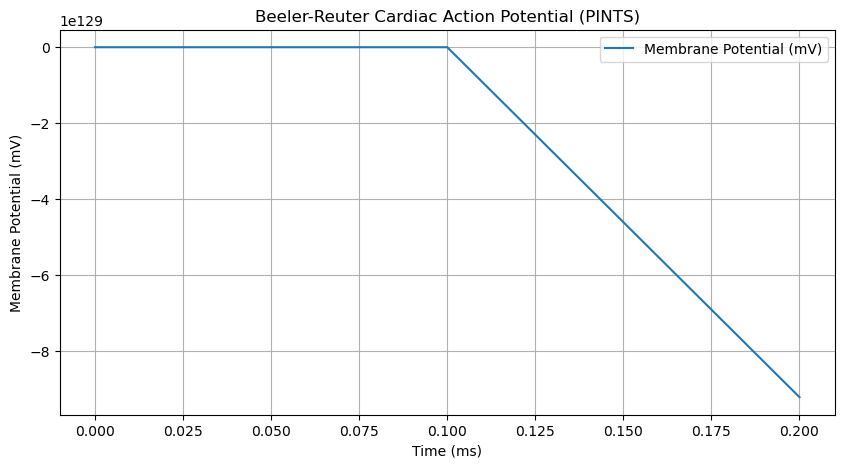

In [5]:
class BeelerReuterModel(pints.ForwardModel):
    """
    Beeler-Reuter cardiac action potential model as a PINTS forward model.
    """
    def __init__(self):
        super(BeelerReuterModel, self).__init__()

        # Membrane capacitance (uF/cm^2)
        self.Cm = 1.0

        # Maximum conductances (mS/cm^2)
        self.g_Na = 4.0
        self.g_si = 0.09
        self.g_K = 0.282
        self.g_K1 = 0.6047
        self.g_L = 0.0003

        # Reversal potentials (mV)
        self.E_Na = 50.0
        self.E_si = 13.0
        self.E_K = -77.0
        self.E_L = -54.4

    def n_parameters(self):
        # We will optimize only the stimulus current
        return 1

    def simulate(self, parameters, times):
        """
        Simulate the Beeler-Reuter model over the provided time points.
        """
        I_stim = parameters[0]  # External stimulus current

        # Initial conditions
        V = -84.624  # Membrane potential (mV)
        m, h, j, d, f, x1 = 0.011, 0.988, 0.975, 0.003, 0.994, 0.0001

        dt = times[1] - times[0]
        V_trace = []

        for t in times:
            # Apply stimulus between 10 and 11 ms
            I_ext = I_stim if 10 < t < 11 else 0

            # Gating kinetics (simplified)
            alpha_m = 0.32 * (V + 47.13) / (1 - np.exp(-0.1 * (V + 47.13)))
            beta_m = 0.08 * np.exp(-V / 11)

            alpha_h = 0.135 * np.exp((80 + V) / -6.8)
            beta_h = 3.56 * np.exp(0.079 * V) + 310000 * np.exp(0.35 * V)

            alpha_j = (-127140 * np.exp(0.2444 * V) - 0.00003474 * np.exp(-0.04391 * V)) * (V + 37.78) / (1 + np.exp(0.311 * (V + 79.23)))
            beta_j = 0.1212 * np.exp(-0.01052 * V) / (1 + np.exp(-0.1378 * (V + 40.14)))

            # Gating updates
            m += dt * (alpha_m * (1 - m) - beta_m * m)
            h += dt * (alpha_h * (1 - h) - beta_h * h)
            j += dt * (alpha_j * (1 - j) - beta_j * j)

            # Ionic currents
            I_Na = self.g_Na * m**3 * h * j * (V - self.E_Na)
            I_si = self.g_si * d * f * (V - self.E_si)
            I_K = self.g_K * x1**2 * (V - self.E_K)
            I_K1 = self.g_K1 * (V - self.E_K) / (1 + np.exp(0.07 * (V + 80)))
            I_L = self.g_L * (V - self.E_L)

            # Total current
            I_total = I_Na + I_si + I_K + I_K1 + I_L + I_ext

            # Membrane potential update
            dV = -I_total / self.Cm
            V += dV * dt

            V_trace.append(V)

        return np.array(V_trace)

# -------------------------
# Simulation and Plotting
# -------------------------

# Time array
time = np.linspace(0, 400, 4000)  # 400 ms

# Instantiate the Beeler-Reuter model
model = BeelerReuterModel()

# Initial parameter: external stimulus current
initial_parameters = [15]  # Injected current of 15 uA/cm^2

# Simulate
V_trace = model.simulate(initial_parameters, time)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(time, V_trace, label='Membrane Potential (mV)')
plt.title('Beeler-Reuter Cardiac Action Potential (PINTS)')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.legend()
plt.grid()
plt.show()
